[![Google Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/ML4ITS/TimeVQVAE/blob/main/.google_colab/TimeVQVAE%20(generation%20only).ipynb)

# ❗❗ Make sure to change your notebook setting to GPU.

## Prerequisite library installation

In [ ]:
!pip install einops x_transformers==1.9.2 supervised_FCN torch==1.13.1

## Download UCR_DataSummary and the pretrained models

In [ ]:
# download UCR_DataSummary.csv
!wget -O UCR_DataSummary.csv -P /content/ https://www.cs.ucr.edu/~eamonn/time_series_data_2018/DataSummary.csv

# download the pretrained models
!wget -O saved_models.zip -P /content/ https://figshare.com/ndownloader/files/39146453

# unzip
!unzip saved_models.zip -d saved_models

In [ ]:
#@title Define `utils/__init__.py`

"""
utils/__init__.py
"""
import os
import pickle
import logging
import yaml
import tempfile
from einops import rearrange

import pandas as pd
import torch
import torch.nn.functional as F
import numpy as np
from pathlib import Path

from sklearn.preprocessing import MinMaxScaler


def get_root_dir():
    # return Path(__file__).parent.parent
    return Path('/content')
# root_dir = Path(__file__).parent.parent
prefix = os.path.join('datasets', 'processed')


def load_yaml_param_settings(yaml_fname: str):
    """
    :param yaml_fname: .yaml file that consists of hyper-parameter settings.
    """
    stream = open(yaml_fname, 'r')
    config = yaml.load(stream, Loader=yaml.FullLoader)
    return config


def preprocess(df, scaler: MinMaxScaler, kind: str):
    """returns normalized and standardized data.
    """

    df = np.asarray(df, dtype=np.float32)

    if len(df.shape) == 1:
        raise ValueError('Data must be a 2-D array')

    if np.any(sum(np.isnan(df)) != 0):
        print('Data contains null values. Will be replaced with 0')
        df = np.nan_to_num()

    # normalize data (corrected)
    if kind == 'train':
        df = scaler.fit_transform(df)
    elif kind == 'test':
        df = scaler.transform(df)
    # df = MinMaxScaler().fit_transform(df)  # -> previous incorrect scaling method
    print('Data normalized')

    return df


def minibatch_slices_iterator(length, step_size,
                              ignore_incomplete_batch=False):
    """
    Iterate through all the mini-batch slices.

    Args:
        length (int): Total length of data in an epoch.
        step_size (int):
        ignore_incomplete_batch (bool): If :obj:`True`, discard the final
            batch if it contains less than `batch_size` number of items.
            (default :obj:`False`)

    Yields
        slice: Slices of each mini-batch.  The last mini-batch may contain
               less indices than `batch_size`.
    """
    start = 0
    stop1 = (length // step_size) * step_size
    while start < stop1:
        yield slice(start, start + step_size, 1)
        start += step_size
    if not ignore_incomplete_batch and start < length:
        yield slice(start, length, 1)


class BatchSlidingWindow(object):
    """
    Class for obtaining mini-batch iterators of sliding windows.

    Each mini-batch will have `batch_size` windows.  If the final batch
    contains less than `batch_size` windows, it will be discarded if
    `ignore_incomplete_batch` is :obj:`True`.

    Args:
        array_size (int): Size of the arrays to be iterated.
        window_size (int): The size of the windows.
        batch_size (int): Size of each mini-batch.
        excludes (np.ndarray): 1-D `bool` array, indicators of whether
            or not to totally exclude a point.  If a point is excluded,
            any window which contains that point is excluded.
            (default :obj:`None`, no point is totally excluded)
        shuffle (bool): If :obj:`True`, the windows will be iterated in
            shuffled order. (default :obj:`False`)
        ignore_incomplete_batch (bool): If :obj:`True`, discard the final
            batch if it contains less than `batch_size` number of windows.
            (default :obj:`False`)
    """

    def __init__(self, array_size, window_size, step_size, batch_size, excludes=None,
                 shuffle=False, ignore_incomplete_batch=False):
        # check the parameters
        if window_size < 1:
            raise ValueError('`window_size` must be at least 1')
        if array_size < window_size:
            raise ValueError('`array_size` must be at least as large as '
                             '`window_size`')
        if excludes is not None:
            excludes = np.asarray(excludes, dtype=np.bool)
            expected_shape = (array_size,)
            if excludes.shape != expected_shape:
                raise ValueError('The shape of `excludes` is expected to be '
                                 '{}, but got {}'.
                                 format(expected_shape, excludes.shape))

        # compute which points are not excluded
        if excludes is not None:
            mask = np.logical_not(excludes)
        else:
            mask = np.ones([array_size], dtype=np.bool)
        mask[: window_size - 1] = False
        where_excludes = np.where(excludes)[0]
        for k in range(1, window_size):
            also_excludes = where_excludes + k
            also_excludes = also_excludes[also_excludes < array_size]
            mask[also_excludes] = False

        # generate the indices of window endings
        indices = np.arange(array_size)[mask]
        self._indices = indices.reshape([-1, 1])

        # the offset array to generate the windows
        self._offsets = np.arange(-window_size + 1, 1)

        # memorize arguments
        self._array_size = array_size
        self._window_size = window_size
        self._step_size = step_size
        self._batch_size = batch_size
        self._shuffle = shuffle
        self._ignore_incomplete_batch = ignore_incomplete_batch

    def get_iterator(self, arrays):
        """
        Iterate through the sliding windows of each array in `arrays`.

        This method is not re-entrant, i.e., calling :meth:`get_iterator`
        would invalidate any previous obtained iterator.

        Args:
            arrays (Iterable[np.ndarray]): 1-D arrays to be iterated.

        Yields:
            tuple[np.ndarray]: The windows of arrays of each mini-batch.
        """
        # check the parameters
        arrays = tuple(np.asarray(a) for a in arrays)
        if not arrays:
            raise ValueError('`arrays` must not be empty')

        # shuffle if required
        if self._shuffle:
            np.random.shuffle(self._indices)

        # iterate through the mini-batches
        for s in minibatch_slices_iterator(
                length=len(self._indices),
                step_size=self._step_size,
                ignore_incomplete_batch=self._ignore_incomplete_batch):
            idx = self._indices[s] + self._offsets
            yield tuple(a[idx] if len(a.shape) == 1 else a[idx, :] for a in arrays)


def freeze(model):
    for param in model.parameters():
        param.requires_grad = False


def unfreeze(model):
    for param in model.parameters():
        param.requires_grad = True


def save_model(models_dict: dict, dirname='saved_models', id: str = ''):
    """
    :param models_dict: {'model_name': model, ...}
    """
    try:
        if not os.path.isdir(get_root_dir().joinpath(dirname)):
            os.mkdir(get_root_dir().joinpath(dirname))

        id_ = id[:]
        if id != '':
            id_ = '-' + id_
        for model_name, model in models_dict.items():
            torch.save(model.state_dict(), get_root_dir().joinpath(dirname, model_name + id_ + '.ckpt'))
    except PermissionError:
        # dirname = tempfile.mkdtemp()
        dirname = tempfile.gettempdir()
        print(f'\nThe trained model is saved in the following temporary dirname due to some permission error: {dirname}.\n')

        id_ = id[:]
        if id != '':
            id_ = '-' + id_
        for model_name, model in models_dict.items():
            torch.save(model.state_dict(), get_root_dir().joinpath(dirname, model_name + id_ + '.ckpt'))


def time_to_timefreq(x, n_fft: int, C: int):
    """
    x: (B, C, L)
    """
    x = rearrange(x, 'b c l -> (b c) l')
    x = torch.stft(x, n_fft, normalized=False, return_complex=False)  # (B, N, T, 2); 2: (real, imag)
    x = rearrange(x, '(b c) n t z -> b (c z) n t ', c=C)  # z=2 (real, imag)
    return x  # (B, C, H, W)


def timefreq_to_time(x, n_fft: int, C: int):
    x = rearrange(x, 'b (c z) n t -> (b c) n t z', c=C)
    x = torch.istft(x, n_fft, normalized=False, return_complex=False)
    x = rearrange(x, '(b c) l -> b c l', c=C)
    return x


def compute_var_loss(z):
    return torch.relu(1. - torch.sqrt(z.var(dim=0) + 1e-4)).mean()


def compute_cov_loss(z):
    norm_z = (z - z.mean(dim=0))
    norm_z = F.normalize(norm_z, p=2, dim=0)  # (batch * feature); l2-norm
    fxf_cov_z = torch.mm(norm_z.T, norm_z)  # (feature * feature)
    ind = np.diag_indices(fxf_cov_z.shape[0])
    fxf_cov_z[ind[0], ind[1]] = torch.zeros(fxf_cov_z.shape[0]).to(norm_z.device)
    cov_loss = (fxf_cov_z ** 2).mean()
    return cov_loss


def quantize(z, vq_model, transpose_channel_length_axes=False):
    input_dim = len(z.shape) - 2
    if input_dim == 2:
        h, w = z.shape[2:]
        z = rearrange(z, 'b c h w -> b (h w) c')
        z_q, indices, vq_loss, perplexity = vq_model(z)
        z_q = rearrange(z_q, 'b (h w) c -> b c h w', h=h, w=w)
    elif input_dim == 1:
        if transpose_channel_length_axes:
            z = rearrange(z, 'b c l -> b (l) c')
        z_q, indices, vq_loss, perplexity = vq_model(z)
        if transpose_channel_length_axes:
            z_q = rearrange(z_q, 'b (l) c -> b c l')
    else:
        raise ValueError
    return z_q, indices, vq_loss, perplexity


def zero_pad_high_freq(xf):
    """
    xf: (B, C, H, W); H: frequency-axis, W: temporal-axis
    """
    xf_l = torch.zeros(xf.shape).to(xf.device)
    xf_l[:, :, 0, :] = xf[:, :, 0, :]
    return xf_l


def zero_pad_low_freq(xf):
    """
    xf: (B, C, H, W); H: frequency-axis, W: temporal-axis
    """
    xf_h = torch.zeros(xf.shape).to(xf.device)
    xf_h[:, :, 1:, :] = xf[:, :, 1:, :]
    return xf_h

def compute_emb_loss(codebook, x, use_cosine_sim, esm_max_codes):
    embed = codebook.embed
    flatten = x.reshape(-1, x.shape[-1])

    if use_cosine_sim:
        flatten = F.normalize(flatten, p=2, dim=-1)
        embed = F.normalize(embed, p=2, dim=-1)

    # N samples can be sampled fro embed for the memory efficiency.
    ind = torch.randint(0, embed.shape[0], size=(min(esm_max_codes, embed.shape[0]),))
    embed = embed[ind]

    cov_embed = torch.cov(embed.t())  # (D, D)
    cov_x = torch.cov(flatten.t())  # (D, D)

    mean_embed = torch.mean(embed, dim=0)
    mean_x = torch.mean(flatten, dim=0)

    esm_loss = F.mse_loss(cov_x.detach(), cov_embed) + F.mse_loss(mean_x.detach(), mean_embed)
    return esm_loss


def compute_downsample_rate(input_length: int,
                            n_fft: int,
                            downsampled_width: int):
    return round(input_length / (np.log2(n_fft) - 1) / downsampled_width) if input_length >= downsampled_width else 1


In [ ]:
#@title Define `generators/bidirectional_transformer.py`

"""
generators/bidirectional_transformer.py
"""
import math
from typing import Union

import torch
import torch.nn as nn
from einops import repeat
from x_transformers import ContinuousTransformerWrapper, Encoder as TFEncoder


def load_pretrained_tok_emb(pretrained_tok_emb, tok_emb, freeze_pretrained_tokens: bool):
    """
    :param pretrained_tok_emb: pretrained token embedding from stage 1
    :param tok_emb: token embedding of the transformer
    :return:
    """
    with torch.no_grad():
        if pretrained_tok_emb != None:
            tok_emb.weight[:-1, :] = pretrained_tok_emb
            if freeze_pretrained_tokens:
                tok_emb.weight[:-1, :].requires_grad = False


class BidirectionalTransformer(nn.Module):
    def __init__(self,
                 kind: str,
                 num_tokens: int,
                 codebook_sizes: dict,
                 embed_dim: int,
                 hidden_dim: int,
                 n_layers: int,
                 heads: int,
                 ff_mult: int,
                 use_rmsnorm: bool,
                 p_unconditional: float,
                 n_classes: int,
                 pretrained_tok_emb_l: nn.Parameter = None,
                 pretrained_tok_emb_h: nn.Parameter = None,
                 freeze_pretrained_tokens: bool = False,
                 num_tokens_l: int = None,
                 **kwargs):
        """
        :param kind:
        :param num_tokens:
        :param codebook_sizes:
        :param embed_dim:
        :param hidden_dim:
        :param n_layers:
        :param heads:
        :param ff_mult:
        :param use_rmsnorm:
        :param p_unconditional:
        :param n_classes:
        :param pretrained_tok_emb_l: if given, the embedding of the transformer is initialized with the pretrained embedding from stage 1; low-frequency
        :param pretrained_tok_emb_h: if given, the embedding of the transformer is initialized with the pretrained embedding from stage 1; high-frequency
        :param freeze_pretrained_tokens:
        :param num_tokens_l:
        :param kwargs:
        """
        super().__init__()
        assert kind in ['LF', 'HF']
        self.kind = kind
        self.num_tokens = num_tokens
        self.n_classes = n_classes
        self.p_unconditional = p_unconditional
        in_dim = embed_dim if kind == 'LF' else 2 * embed_dim
        out_dim = embed_dim

        # token embeddings
        self.tok_emb_l = nn.Embedding(codebook_sizes['lf'] + 1, embed_dim)  # `+1` is for mask-token
        load_pretrained_tok_emb(pretrained_tok_emb_l, self.tok_emb_l, freeze_pretrained_tokens)
        if kind == 'HF':
            self.tok_emb_h = nn.Embedding(codebook_sizes['hf'] + 1, embed_dim)  # `+1` is for mask-token
            load_pretrained_tok_emb(pretrained_tok_emb_h, self.tok_emb_h, freeze_pretrained_tokens)

        # transformer
        self.pos_emb = nn.Embedding(self.num_tokens + 1, in_dim)
        self.class_condition_emb = nn.Embedding(n_classes + 1, in_dim)  # `+1` is for no-condition
        self.blocks = ContinuousTransformerWrapper(dim_in=in_dim,
                                                   dim_out=in_dim,
                                                   max_seq_len=self.num_tokens + 1,
                                                   attn_layers=TFEncoder(
                                                       dim=hidden_dim,
                                                       depth=n_layers,
                                                       heads=heads,
                                                       use_rmsnorm=use_rmsnorm,
                                                       ff_mult=ff_mult,
                                                       use_abs_pos_emb=False,
                                                   ))
        self.Token_Prediction = nn.Sequential(*[
            nn.Linear(in_features=in_dim, out_features=out_dim),
            nn.GELU(),
            nn.LayerNorm(out_dim, eps=1e-12)
        ])
        codebook_size = codebook_sizes['lf'] if kind == 'LF' else codebook_sizes['hf']
        self.bias = nn.Parameter(torch.zeros(self.num_tokens, codebook_size + 1))
        self.ln = nn.LayerNorm(in_dim, eps=1e-12)
        self.drop = nn.Dropout(p=0.)

        if kind == 'HF':
            self.projector = nn.Conv1d(num_tokens_l, self.num_tokens, kernel_size=1)

    def class_embedding(self, class_condition: Union[None, torch.Tensor], batch_size: int, device):
        if isinstance(class_condition, torch.Tensor):
            # if condition is given (conditional sampling)
            conditional_ind = torch.rand(class_condition.shape).to(device) > self.p_unconditional
            class_uncondition = repeat(torch.Tensor([self.n_classes]).long().to(device), 'i -> b i', b=batch_size)  # (b 1)
            class_condition = torch.where(conditional_ind, class_condition.long(), class_uncondition)  # (b 1)
        else:
            # if condition is not given (unconditional sampling)
            class_uncondition = repeat(torch.Tensor([self.n_classes]).long().to(device), 'i -> b i', b=batch_size)  # (b 1)
            class_condition = class_uncondition
        cls_emb = self.class_condition_emb(class_condition)  # (b 1 dim)
        return cls_emb

    def forward_lf(self, embed_ind_l, class_condition: Union[None, torch.Tensor] = None):
        device = embed_ind_l.device

        token_embeddings = self.tok_emb_l(embed_ind_l)  # (b n dim)
        cls_emb = self.class_embedding(class_condition, embed_ind_l.shape[0], device)  # (b 1 dim)

        n = token_embeddings.shape[1]
        position_embeddings = self.pos_emb.weight[:n, :]
        embed = self.drop(self.ln(token_embeddings + position_embeddings))  # (b, n, dim)
        embed = torch.cat((cls_emb, embed), dim=1)  # (b, 1+n, dim)
        embed = self.blocks(embed)  # (b, 1+n, dim)
        embed = self.Token_Prediction(embed)[:, 1:, :]  # (b, n, dim)

        logits = torch.matmul(embed, self.tok_emb_l.weight.T) + self.bias  # (b, n, codebook_size+1)
        logits = logits[:, :, :-1]  # remove the logit for the mask token.  # (b, n, codebook_size)
        return logits

    def forward_hf(self, embed_ind_l, embed_ind_h, class_condition=None):
        """
        embed_ind_l (b n)
        embed_ind_h (b m); m > n
        """
        device = embed_ind_l.device

        token_embeddings_l = self.tok_emb_l(embed_ind_l)  # (b n dim)
        token_embeddings_l = self.projector(token_embeddings_l)  # (b m dim)
        token_embeddings_h = self.tok_emb_h(embed_ind_h)  # (b m dim)
        token_embeddings = torch.cat((token_embeddings_l, token_embeddings_h), dim=-1)  # (b m 2*dim)
        cls_emb = self.class_embedding(class_condition, embed_ind_l.shape[0], device)  # (b 1 2*dim)

        n = token_embeddings.shape[1]
        position_embeddings = self.pos_emb.weight[:n, :]
        embed = self.drop(self.ln(token_embeddings + position_embeddings))  # (b, m, 2*dim)
        embed = torch.cat((cls_emb, embed), dim=1)  # (b, 1+m, 2*dim)
        embed = self.blocks(embed)  # (b, 1+m, 2*dim)
        embed = self.Token_Prediction(embed)[:, 1:, :]  # (b, m, dim)

        logits = torch.matmul(embed, self.tok_emb_h.weight.T) + self.bias  # (b, m, codebook_size+1)
        logits = logits[:, :, :-1]  # remove the logit for the mask token.  # (b, m, codebook_size)
        return logits

    def forward(self, embed_ind_l, embed_ind_h=None, class_condition: Union[None, torch.Tensor] = None):
        """
        embed_ind: indices for embedding; (b n)
        class_condition: (b 1); if None, unconditional sampling is operated.
        """
        if self.kind == 'LF':
            logits = self.forward_lf(embed_ind_l, class_condition)
        elif self.kind == 'HF':
            logits = self.forward_hf(embed_ind_l, embed_ind_h, class_condition)
        else:
            raise ValueError
        return logits


In [ ]:
#@title Define `encoder_decoders/vq_vae_encdec.py`

"""
encoder_decoders/vq_vae_encdec.py
"""
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np


class ResBlock(nn.Module):
    def __init__(self, in_channels, out_channels, mid_channels=None, bn=False):
        super(ResBlock, self).__init__()

        if mid_channels is None:
            mid_channels = out_channels

        layers = [
            nn.LeakyReLU(),
            nn.Conv2d(in_channels, mid_channels,
                      kernel_size=3, stride=1, padding=1),
            nn.LeakyReLU(),
            nn.Conv2d(mid_channels, out_channels,
                      kernel_size=1, stride=1, padding=0)
        ]
        if bn:
            layers.insert(2, nn.BatchNorm2d(out_channels))
        self.convs = nn.Sequential(*layers)

    def forward(self, x):
        return x + self.convs(x)


class VQVAEEncBlock(nn.Module):
    def __init__(self,
                 in_channels,
                 out_channels,
                 ):
        super().__init__()
        self.block = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=(3, 4), stride=(1, 2), padding=(1, 1),
                      padding_mode='replicate'),
            nn.BatchNorm2d(out_channels),
            nn.LeakyReLU(inplace=True))

    def forward(self, x):
        out = self.block(x)
        return out


class VQVAEDecBlock(nn.Module):
    def __init__(self,
                 in_channels,
                 out_channels,
                 ):
        super().__init__()
        self.block = nn.Sequential(
            nn.ConvTranspose2d(in_channels, out_channels, kernel_size=(3, 4), stride=(1, 2), padding=(1, 1)),
            nn.BatchNorm2d(out_channels),
            nn.LeakyReLU(inplace=True))

    def forward(self, x):
        out = self.block(x)
        return out


class VQVAEEncoder(nn.Module):
    """
    following the same implementation from the VQ-VAE paper.
    """

    def __init__(self,
                 d: int,
                 num_channels: int,
                 downsample_rate: int,
                 n_resnet_blocks: int,
                 bn: bool = True,
                 **kwargs):
        """
        :param d: hidden dimension size
        :param num_channels: channel size of input
        :param downsample_rate: should be a factor of 2; e.g., 2, 4, 8, 16, ...
        :param n_resnet_blocks: number of ResNet blocks
        :param bn: use of BatchNorm
        :param kwargs:
        """
        super().__init__()
        self.encoder = nn.Sequential(
            VQVAEEncBlock(num_channels, d),
            *[VQVAEEncBlock(d, d) for _ in range(int(np.log2(downsample_rate)) - 1)],
            *[nn.Sequential(ResBlock(d, d, bn=bn), nn.BatchNorm2d(d)) for _ in range(n_resnet_blocks)],
        )

        self.is_num_tokens_updated = False
        self.register_buffer('num_tokens', torch.zeros(1).int())
        self.register_buffer('H_prime', torch.zeros(1).int())
        self.register_buffer('W_prime', torch.zeros(1).int())

    def forward(self, x):
        """
        :param x: (B, C, H, W)
        :return (B, C, H, W') where W' <= W
        """
        out = self.encoder(x)
        if not self.is_num_tokens_updated:
            self.H_prime += out.shape[2]
            self.W_prime += out.shape[3]
            self.num_tokens += self.H_prime * self.W_prime
            self.is_num_tokens_updated = True
        return out


class VQVAEDecoder(nn.Module):
    """
    following the same implementation from the VQ-VAE paper.
    """

    def __init__(self,
                 d: int,
                 num_channels: int,
                 downsample_rate: int,
                 n_resnet_blocks: int,
                 **kwargs):
        """
        :param d: hidden dimension size
        :param num_channels: channel size of input
        :param downsample_rate: should be a factor of 2; e.g., 2, 4, 8, 16, ...
        :param n_resnet_blocks: number of ResNet blocks
        :param kwargs:
        """
        super().__init__()
        self.decoder = nn.Sequential(
            *[nn.Sequential(ResBlock(d, d), nn.BatchNorm2d(d)) for _ in range(n_resnet_blocks)],
            *[VQVAEDecBlock(d, d) for _ in range(int(np.log2(downsample_rate)) - 1)],
            nn.ConvTranspose2d(d, num_channels, kernel_size=(3, 4), stride=(1, 2), padding=(1, 1)),
            nn.ConvTranspose2d(num_channels, num_channels, kernel_size=(3, 4), stride=(1, 2), padding=(1, 1)),  # one more upsampling layer is added not to miss reconstruction details
        )

        self.is_upsample_size_updated = False
        self.register_buffer("upsample_size", torch.zeros(2))

    def register_upsample_size(self, hw: torch.IntTensor):
        """
        :param hw: (height H, width W) of input
        """
        self.upsample_size = hw
        self.is_upsample_size_updated = True

    def forward(self, x):
        """
        :param x: output from the encoder (B, C, H, W')
        :return  (B, C, H, W)
        """
        out = self.decoder(x)
        if isinstance(self.upsample_size, torch.Tensor):
            upsample_size = self.upsample_size.cpu().numpy().astype(int)
            upsample_size = [*upsample_size]
            out = F.interpolate(out, size=upsample_size, mode='bilinear', align_corners=True)
            return out
        else:
            raise ValueError('self.upsample_size is not yet registered.')

In [ ]:
#@title Define `vector_quantization/vq.py`

"""
vector_quantization/vq.py
"""
"""
The code is taken from https://github.com/lucidrains/vector-quantize-pytorch
"""
import copy
import torch
from torch import nn, einsum
import torch.nn.functional as F
import torch.distributed as distributed
from torch.cuda.amp import autocast
from torch.distributions.categorical import Categorical

from einops import rearrange, repeat
from contextlib import contextmanager

# from utils import *
from x_transformers import ContinuousTransformerWrapper, Encoder as TFEncoder, Decoder as TFDecoder


def exists(val):
    return val is not None


def default(val, d):
    return val if exists(val) else d


def noop(*args, **kwargs):
    pass


def l2norm(t):
    return F.normalize(t, p=2, dim=-1)


def log(t, eps=1e-20):
    return torch.log(t.clamp(min=eps))


def gumbel_noise(t):
    noise = torch.zeros_like(t).uniform_(0, 1)
    return -log(-log(noise))


def gumbel_sample(t, temperature=1., dim=-1):
    if temperature == 0:
        return t.argmax(dim=dim)

    return ((t / temperature) + gumbel_noise(t)).argmax(dim=dim)


def softmax_sample(t, temperature=1., dim=-1):
    if temperature == 0:
        return t.argmax(dim=dim)

    m = Categorical(logits=t / temperature)
    return m.sample()


def ema_inplace(moving_avg, new, decay):
    moving_avg.data.mul_(decay).add_(new, alpha=(1 - decay))


def laplace_smoothing(x, n_categories, eps=1e-5):
    return (x + eps) / (x.sum() + n_categories * eps)


def sample_vectors(samples, num):
    num_samples, device = samples.shape[0], samples.device

    if num_samples >= num:
        indices = torch.randperm(num_samples, device=device)[:num]
    else:
        indices = torch.randint(0, num_samples, (num,), device=device)

    return samples[indices]


def kmeans(samples, num_clusters, num_iters=10, use_cosine_sim=False):
    dim, dtype, device = samples.shape[-1], samples.dtype, samples.device

    means = sample_vectors(samples, num_clusters)

    for _ in range(num_iters):
        if use_cosine_sim:
            dists = samples @ means.t()
        else:
            diffs = rearrange(samples, 'n d -> n () d') - rearrange(means, 'c d -> () c d')
            dists = -(diffs ** 2).sum(dim=-1)

        buckets = dists.max(dim=-1).indices
        bins = torch.bincount(buckets, minlength=num_clusters)
        zero_mask = bins == 0
        bins_min_clamped = bins.masked_fill(zero_mask, 1)

        new_means = buckets.new_zeros(num_clusters, dim, dtype=dtype)
        new_means.scatter_add_(0, repeat(buckets, 'n -> n d', d=dim), samples)
        new_means = new_means / bins_min_clamped[..., None]

        if use_cosine_sim:
            new_means = l2norm(new_means)

        means = torch.where(zero_mask[..., None], means, new_means)

    return means, bins


# regularization losses

def orthgonal_loss_fn(t):
    # eq (2) from https://arxiv.org/abs/2112.00384
    n = t.shape[0]
    normed_codes = l2norm(t)
    identity = torch.eye(n, device=t.device)
    cosine_sim = einsum('i d, j d -> i j', normed_codes, normed_codes)
    return ((cosine_sim - identity) ** 2).sum() / (n ** 2)


# distance types

class EuclideanCodebook(nn.Module):
    """
    source: https://github.com/lucidrains/vector-quantize-pytorch/blob/master/vector_quantize_pytorch/vector_quantize_pytorch.py
    """
    def __init__(
            self,
            dim,
            codebook_size,
            kmeans_init=False,
            kmeans_iters=10,
            decay=0.8,
            eps=1e-5,
            threshold_ema_dead_code=2,
            use_ddp=False,
            learnable_codebook=False,
            sample_codebook_temp=0,
            emb_dropout=0.,
    ):
        super().__init__()
        self.decay = decay
        init_fn = torch.randn if not kmeans_init else torch.zeros
        embed = init_fn(codebook_size, dim)

        self.codebook_size = codebook_size
        self.kmeans_iters = kmeans_iters
        self.eps = eps
        self.threshold_ema_dead_code = threshold_ema_dead_code
        self.sample_codebook_temp = sample_codebook_temp
        self.emb_dropout = emb_dropout

        self.all_reduce_fn = distributed.all_reduce if use_ddp else noop

        self.register_buffer('initted', torch.Tensor([not kmeans_init]))
        self.register_buffer('cluster_size', torch.zeros(codebook_size))
        self.register_buffer('embed_avg', embed.clone())

        self.learnable_codebook = learnable_codebook
        if learnable_codebook:
            self.embed = nn.Parameter(embed)
        else:
            self.register_buffer('embed', embed)

        self.embed_onehot = None
        self.perplexity = None

    @torch.jit.ignore
    def init_embed_(self, data):
        if self.initted:
            return

        embed, cluster_size = kmeans(data, self.codebook_size, self.kmeans_iters)
        self.embed.data.copy_(embed)
        self.embed_avg.data.copy_(embed.clone())
        self.cluster_size.data.copy_(cluster_size)
        self.initted.data.copy_(torch.Tensor([True]))

    def replace(self, samples, mask):
        modified_codebook = torch.where(
            mask[..., None],
            sample_vectors(samples, self.codebook_size),
            self.embed
        )
        self.embed.data.copy_(modified_codebook)

    def expire_codes_(self, batch_samples):
        if self.threshold_ema_dead_code == 0:
            return

        expired_codes = self.cluster_size < self.threshold_ema_dead_code
        if not torch.any(expired_codes):
            return
        batch_samples = rearrange(batch_samples, '... d -> (...) d')
        self.replace(batch_samples, mask=expired_codes)

    @autocast(enabled=False)
    def forward(self, x):
        shape, dtype = x.shape, x.dtype
        flatten = rearrange(x, '... d -> (...) d')

        self.init_embed_(flatten)

        embed = self.embed if not self.learnable_codebook else self.embed.detach()
        embed = embed.t()

        if self.emb_dropout and self.training:
            embed = F.dropout(embed, self.emb_dropout)

        dist = -(
                flatten.pow(2).sum(1, keepdim=True)
                - 2 * flatten @ embed
                + embed.pow(2).sum(0, keepdim=True)
        )
        # embed_ind = gumbel_sample(dist, dim=-1, temperature=self.sample_codebook_temp)
        embed_ind = softmax_sample(dist, dim=-1, temperature=self.sample_codebook_temp)
        embed_onehot = F.one_hot(embed_ind, self.codebook_size).type(dtype)
        embed_ind = embed_ind.view(*shape[:-1])
        quantize = F.embedding(embed_ind, self.embed)

        if self.training:
            cluster_size = embed_onehot.sum(0)
            self.all_reduce_fn(cluster_size)

            ema_inplace(self.cluster_size, cluster_size, self.decay)

            embed_sum = flatten.t() @ embed_onehot
            self.all_reduce_fn(embed_sum)

            ema_inplace(self.embed_avg, embed_sum.t(), self.decay)
            cluster_size = laplace_smoothing(self.cluster_size, self.codebook_size, self.eps) * self.cluster_size.sum()
            embed_normalized = self.embed_avg / cluster_size.unsqueeze(1)
            self.embed.data.copy_(embed_normalized)
            self.expire_codes_(x)

        # perplexity
        avg_probs = torch.mean(embed_onehot, dim=0)  # (K,)
        perplexity = torch.exp(-torch.sum(avg_probs * torch.log(avg_probs + 1e-10)))
        self.embed_onehot = embed_onehot.detach()  # .cpu()
        self.perplexity = perplexity.detach()  # .cpu()

        return quantize, embed_ind


# main class
class VectorQuantize(nn.Module):
    def __init__(
            self,
            dim,
            codebook_size,
            codebook_dim=None,
            heads=1,
            decay=0.8,
            eps=1e-5,
            kmeans_init=False,
            kmeans_iters=10,
            use_cosine_sim=False,
            threshold_ema_dead_code=0,
            channel_last=True,
            accept_image_fmap=False,
            commitment_weight=1.,
            orthogonal_reg_weight=0.,
            orthogonal_reg_active_codes_only=False,
            orthogonal_reg_max_codes=None,
            sample_codebook_temp=0.,
            sync_codebook=False,
            emb_dropout=0.,
            **kwargs
    ):
        super().__init__()
        self.heads = heads
        codebook_dim = default(codebook_dim, dim)
        codebook_input_dim = codebook_dim * heads

        requires_projection = codebook_input_dim != dim
        self.project_in = nn.Linear(dim, codebook_input_dim) if requires_projection else nn.Identity()
        self.project_out = nn.Linear(codebook_input_dim, dim) if requires_projection else nn.Identity()

        self.eps = eps
        self.commitment_weight = commitment_weight

        has_codebook_orthogonal_loss = orthogonal_reg_weight > 0
        self.orthogonal_reg_weight = orthogonal_reg_weight
        self.orthogonal_reg_active_codes_only = orthogonal_reg_active_codes_only
        self.orthogonal_reg_max_codes = orthogonal_reg_max_codes

        codebook_class = EuclideanCodebook

        self._codebook = codebook_class(
            dim=codebook_dim,
            codebook_size=codebook_size,
            kmeans_init=kmeans_init,
            kmeans_iters=kmeans_iters,
            decay=decay,
            eps=eps,
            threshold_ema_dead_code=threshold_ema_dead_code,
            use_ddp=sync_codebook,
            learnable_codebook=has_codebook_orthogonal_loss,
            sample_codebook_temp=sample_codebook_temp,
            emb_dropout=emb_dropout,
        )

        self.codebook_size = codebook_size

        self.accept_image_fmap = accept_image_fmap
        self.channel_last = channel_last

    @property
    def codebook(self):
        return self._codebook.embed

    def forward(self, x):
        """
        x: (B, N, D)
        """
        shape, device, heads, is_multiheaded, codebook_size = x.shape, x.device, self.heads, self.heads > 1, self.codebook_size
        need_transpose = not self.channel_last and not self.accept_image_fmap
        vq_loss = {'loss': torch.tensor([0.], device=device, requires_grad=self.training),
                   'commit_loss': 0.,
                   'orthogonal_reg_loss': 0.,
                   }

        if self.accept_image_fmap:
            height, width = x.shape[-2:]
            x = rearrange(x, 'b c h w -> b (h w) c')

        if need_transpose:
            x = rearrange(x, 'b d n -> b n d')

        x = self.project_in(x)

        if is_multiheaded:
            x = rearrange(x, 'b n (h d) -> (b h) n d', h=heads)

        quantize, embed_ind = self._codebook(x)

        if self.training:
            quantize = x + (quantize - x).detach()  # allows `z`-part to be trainable while `z_q`-part is un-trainable. `z_q` is updated by the EMA.

        if self.training:
            if self.commitment_weight > 0:
                commit_loss = F.mse_loss(quantize.detach(), x)
                vq_loss['commit_loss'] = commit_loss
                vq_loss['loss'] = vq_loss['loss'] + commit_loss * self.commitment_weight

            if self.orthogonal_reg_weight > 0:
                codebook = self.codebook

                if self.orthogonal_reg_active_codes_only:
                    # only calculate orthogonal loss for the activated codes for this batch
                    unique_code_ids = torch.unique(embed_ind)
                    codebook = codebook[unique_code_ids]

                num_codes = codebook.shape[0]
                if exists(self.orthogonal_reg_max_codes) and num_codes > self.orthogonal_reg_max_codes:
                    rand_ids = torch.randperm(num_codes, device=device)[:self.orthogonal_reg_max_codes]
                    codebook = codebook[rand_ids]

                orthogonal_reg_loss = orthgonal_loss_fn(codebook)
                vq_loss['orthogonal_reg_loss'] = orthogonal_reg_loss
                vq_loss['loss'] = vq_loss['loss'] + orthogonal_reg_loss * self.orthogonal_reg_weight

        if is_multiheaded:
            quantize = rearrange(quantize, '(b h) n d -> b n (h d)', h=heads)
            embed_ind = rearrange(embed_ind, '(b h) n -> b n h', h=heads)

        quantize = self.project_out(quantize)

        if need_transpose:
            quantize = rearrange(quantize, 'b n d -> b d n')

        if self.accept_image_fmap:
            quantize = rearrange(quantize, 'b (h w) c -> b c h w', h=height, w=width)
            embed_ind = rearrange(embed_ind, 'b (h w) ... -> b h w ...', h=height, w=width)

        return quantize, embed_ind, vq_loss, self._codebook.perplexity

In [ ]:
#@title Define `generators/maskgit.py`

"""
generators/maskgit.py
"""
import copy
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import math
from pathlib import Path
import tempfile
from typing import Union

from einops import repeat, rearrange
from typing import Callable
# from generators.bidirectional_transformer import BidirectionalTransformer

# from encoder_decoders.vq_vae_encdec import VQVAEEncoder, VQVAEDecoder
# from vector_quantization.vq import VectorQuantize

#from utils import compute_downsample_rate, get_root_dir, freeze, timefreq_to_time, time_to_timefreq, quantize, zero_pad_low_freq, zero_pad_high_freq


class MaskGIT(nn.Module):
    """
    ref: https://github.com/dome272/MaskGIT-pytorch/blob/cff485ad3a14b6ed5f3aa966e045ea2bc8c68ad8/transformer.py#L11
    """

    def __init__(self,
                 input_length: int,
                 choice_temperatures: dict,
                 stochastic_sampling: int,
                 T: int,
                 config: dict,
                 n_classes: int,
                 **kwargs):
        super().__init__()
        self.choice_temperature_l = choice_temperatures['lf']
        self.choice_temperature_h = choice_temperatures['hf']
        self.T = T
        self.config = config
        self.n_classes = n_classes

        self.mask_token_ids = {'LF': config['VQ-VAE']['codebook_sizes']['lf'], 'HF': config['VQ-VAE']['codebook_sizes']['hf']}
        self.gamma = self.gamma_func("cosine")

        # define encoder, decoder, vq_models
        dim = config['encoder']['dim']
        in_channels = config['dataset']['in_channels']
        downsampled_width_l = config['encoder']['downsampled_width']['lf']
        downsampled_width_h = config['encoder']['downsampled_width']['hf']
        self.n_fft = config['VQ-VAE']['n_fft']
        downsample_rate_l = compute_downsample_rate(input_length, self.n_fft, downsampled_width_l)
        downsample_rate_h = compute_downsample_rate(input_length, self.n_fft, downsampled_width_h)
        self.encoder_l = VQVAEEncoder(dim, 2 * in_channels, downsample_rate_l, config['encoder']['n_resnet_blocks'])
        self.decoder_l = VQVAEDecoder(dim, 2 * in_channels, downsample_rate_l, config['decoder']['n_resnet_blocks'])
        self.vq_model_l = VectorQuantize(dim, config['VQ-VAE']['codebook_sizes']['lf'], **config['VQ-VAE'])
        self.encoder_h = VQVAEEncoder(dim, 2 * in_channels, downsample_rate_h, config['encoder']['n_resnet_blocks'])
        self.decoder_h = VQVAEDecoder(dim, 2 * in_channels, downsample_rate_h, config['decoder']['n_resnet_blocks'])
        self.vq_model_h = VectorQuantize(dim, config['VQ-VAE']['codebook_sizes']['hf'], **config['VQ-VAE'])

        # load trained models for encoder, decoder, and vq_models
        dataset_name = self.config['dataset']['dataset_name']
        self.load(self.encoder_l, get_root_dir().joinpath('saved_models'), f'encoder_l-{dataset_name}.ckpt')
        self.load(self.decoder_l, get_root_dir().joinpath('saved_models'), f'decoder_l-{dataset_name}.ckpt')
        self.load(self.vq_model_l, get_root_dir().joinpath('saved_models'), f'vq_model_l-{dataset_name}.ckpt')
        self.load(self.encoder_h, get_root_dir().joinpath('saved_models'), f'encoder_h-{dataset_name}.ckpt')
        self.load(self.decoder_h, get_root_dir().joinpath('saved_models'), f'decoder_h-{dataset_name}.ckpt')
        self.load(self.vq_model_h, get_root_dir().joinpath('saved_models'), f'vq_model_h-{dataset_name}.ckpt')

        # freeze the models for encoder, decoder, and vq_models
        freeze(self.encoder_l)
        freeze(self.decoder_l)
        freeze(self.vq_model_l)
        freeze(self.encoder_h)
        freeze(self.decoder_h)
        freeze(self.vq_model_h)

        # evaluation model for encoder, decoder, and vq_models
        self.encoder_l.eval()
        self.decoder_l.eval()
        self.vq_model_l.eval()
        self.encoder_h.eval()
        self.decoder_h.eval()
        self.vq_model_h.eval()

        # token lengths
        self.num_tokens_l = self.encoder_l.num_tokens.item()
        self.num_tokens_h = self.encoder_h.num_tokens.item()

        # latent space dim
        self.H_prime_l, self.H_prime_h = self.encoder_l.H_prime, self.encoder_h.H_prime
        self.W_prime_l, self.W_prime_h = self.encoder_l.W_prime, self.encoder_h.W_prime

        # pretrained discrete tokens
        embed_l = nn.Parameter(copy.deepcopy(self.vq_model_l._codebook.embed))  # pretrained discrete tokens (LF)
        embed_h = nn.Parameter(copy.deepcopy(self.vq_model_h._codebook.embed))  # pretrained discrete tokens (HF)

        self.transformer_l = BidirectionalTransformer('LF',
                                                      self.num_tokens_l,
                                                      config['VQ-VAE']['codebook_sizes'],
                                                      config['VQ-VAE']['codebook_dim'],
                                                      **config['MaskGIT']['prior_model'],
                                                      n_classes=n_classes,
                                                      pretrained_tok_emb_l=embed_l,
                                                      )

        self.transformer_h = BidirectionalTransformer('HF',
                                                      self.num_tokens_h,
                                                      config['VQ-VAE']['codebook_sizes'],
                                                      config['VQ-VAE']['codebook_dim'],
                                                      **config['MaskGIT']['prior_model'],
                                                      n_classes=n_classes,
                                                      pretrained_tok_emb_l=embed_l,
                                                      pretrained_tok_emb_h=embed_h,
                                                      num_tokens_l=self.num_tokens_l,
                                                      )

        # stochastic codebook sampling
        self.vq_model_l._codebook.sample_codebook_temp = stochastic_sampling
        self.vq_model_h._codebook.sample_codebook_temp = stochastic_sampling

    def load(self, model, dirname, fname):
        """
        model: instance
        path_to_saved_model_fname: path to the ckpt file (i.e., trained model)
        """
        try:
            model.load_state_dict(torch.load(dirname.joinpath(fname)))
        except FileNotFoundError:
            dirname = Path(tempfile.gettempdir())
            model.load_state_dict(torch.load(dirname.joinpath(fname)))

    @torch.no_grad()
    def encode_to_z(self, x, encoder: VQVAEEncoder, vq_model: VectorQuantize, spectrogram_padding: Callable = None):
        """
        x: (B, C, L)
        """
        C = x.shape[1]
        xf = time_to_timefreq(x, self.n_fft, C)  # (B, C, H, W)
        if spectrogram_padding is not None:
            xf = spectrogram_padding(xf)
        z = encoder(xf)  # (b c h w)
        z_q, indices, vq_loss, perplexity = quantize(z, vq_model)  # (b c h w), (b (h w) h), ...
        return z_q, indices

    def forward(self, x, y):
        """
        x: (B, C, L)
        y: (B, 1)
        straight from [https://github.com/dome272/MaskGIT-pytorch/blob/main/transformer.py]
        """
        device = x.device
        _, z_indices_l = self.encode_to_z(x, self.encoder_l, self.vq_model_l, zero_pad_high_freq)  # (b n)
        _, z_indices_h = self.encode_to_z(x, self.encoder_h, self.vq_model_h, zero_pad_low_freq)  # (b m)

        # randomly sample `t`
        t = np.random.uniform(0, 1)

        # create masks
        r = math.floor(self.gamma(t) * z_indices_l.shape[1])
        rand = torch.rand(z_indices_l.shape, device=device)
        sample = rand.topk(r, dim=1).indices
        mask_l = torch.zeros(z_indices_l.shape, dtype=torch.bool, device=device)
        mask_l.scatter_(dim=1, index=sample, value=True)

        r = math.floor(self.gamma(t) * z_indices_h.shape[1])
        rand = torch.rand(z_indices_h.shape, device=device)
        sample = rand.topk(r, dim=1).indices
        mask_h = torch.zeros(z_indices_h.shape, dtype=torch.bool, device=device)
        mask_h.scatter_(dim=1, index=sample, value=True)

        # masked tokens
        masked_indices_l = self.mask_token_ids['LF'] * torch.ones_like(z_indices_l, device=device)
        a_indices = mask_l * z_indices_l + (~mask_l) * masked_indices_l  # (b n); `~` reverses bool-typed data
        masked_indices_h = self.mask_token_ids['HF'] * torch.ones_like(z_indices_h, device=device)
        a_indices_h = mask_h * z_indices_h + (~mask_h) * masked_indices_h  # (b m)

        # prediction
        logits_l = self.transformer_l(a_indices.detach(), class_condition=y)  # (b n codebook_size)
        target_l = z_indices_l  # (b n)

        logits_h = self.transformer_h(target_l.detach(), a_indices_h.detach(), class_condition=y)  # (b m codebook_size)
        target_h = z_indices_h

        return [logits_l, logits_h], [target_l, target_h]  # (2*b, n, codebook_size), (2*b, n),   # (2*b n_classes)

    def gamma_func(self, mode="cosine"):
        if mode == "linear":
            return lambda r: 1 - r
        elif mode == "cosine":
            return lambda r: np.cos(r * np.pi / 2)
        elif mode == "square":
            return lambda r: 1 - r ** 2
        elif mode == "cubic":
            return lambda r: 1 - r ** 3
        else:
            raise NotImplementedError

    def create_input_tokens_normal(self, num, num_tokens, mask_token_ids, device):
        """
        returns masked tokens
        """
        blank_tokens = torch.ones((num, num_tokens), device=device)
        masked_tokens = mask_token_ids * blank_tokens
        return masked_tokens.to(torch.int64)

    def mask_by_random_topk(self, mask_len, probs, temperature=1.0, device='cpu'):
        def log(t, eps=1e-20):
            return torch.log(t.clamp(min=eps))

        def gumbel_noise(t):
            """
            Gumbel max trick: https://neptune.ai/blog/gumbel-softmax-loss-function-guide-how-to-implement-it-in-pytorch
            """
            noise = torch.zeros_like(t).uniform_(0, 1)
            return -log(-log(noise))

        confidence = torch.log(probs) + temperature * gumbel_noise(probs).to(device)  # Gumbel max trick
        sorted_confidence, _ = torch.sort(confidence, dim=-1)
        # Obtains cut off threshold given the mask lengths.
        cut_off = torch.take_along_dim(sorted_confidence, mask_len.to(torch.long), dim=-1)
        # Masks tokens with lower confidence.
        masking = (confidence < cut_off)
        return masking

    def first_pass(self,
                   s_l: torch.Tensor,
                   unknown_number_in_the_beginning_l,
                   class_condition: Union[torch.Tensor, None],
                   guidance_scale: float,
                   gamma: Callable,
                   device):
        for t in range(self.T):
            logits_l = self.transformer_l(s_l, class_condition=class_condition)  # (b n codebook_size)
            if isinstance(class_condition, torch.Tensor):
                logits_l_null = self.transformer_l(s_l, class_condition=None)
                logits_l = logits_l_null + guidance_scale * (logits_l - logits_l_null)
            sampled_ids = torch.distributions.categorical.Categorical(logits=logits_l).sample()
            unknown_map = (s_l == self.mask_token_ids['LF'])  # which tokens need to be sampled -> bool [8, 257]
            sampled_ids = torch.where(unknown_map, sampled_ids, s_l)  # replace all -1 with their samples and leave the others untouched [8, 257]

            # create masking
            ratio = 1. * (t + 1) / self.T  # just a percentage e.g. 1 / 12
            mask_ratio = gamma(ratio)

            probs = F.softmax(logits_l, dim=-1)  # convert logits into probs [8, 257, 1024]
            selected_probs = torch.squeeze(torch.take_along_dim(probs, torch.unsqueeze(sampled_ids, -1), -1), -1)  # get probability for selected tokens in categorical call, also for already sampled ones [8, 257]
            _CONFIDENCE_OF_KNOWN_TOKENS = torch.Tensor([torch.inf]).to(device)
            selected_probs = torch.where(unknown_map, selected_probs, _CONFIDENCE_OF_KNOWN_TOKENS)  # ignore tokens which are already sampled [8, 257]

            mask_len = torch.unsqueeze(torch.floor(unknown_number_in_the_beginning_l * mask_ratio), 1)  # floor(256 * 0.99) = 254 --> [254, 254, 254, 254, ....]
            mask_len = torch.maximum(torch.zeros_like(mask_len), torch.minimum(torch.sum(unknown_map, dim=-1, keepdim=True) - 1, mask_len))  # add -1 later when conditioning and also ones_like. Zeroes just because we have no cond token
            # max(1, min(how many unknown tokens, how many tokens we want to sample))

            # Adds noise for randomness
            masking = self.mask_by_random_topk(mask_len, selected_probs, temperature=self.choice_temperature_l * (1. - ratio), device=device)

            # Masks tokens with lower confidence.
            s_l = torch.where(masking, self.mask_token_ids['LF'], sampled_ids)  # (b n)
        return s_l

    def second_pass(self,
                    s_l: torch.Tensor,
                    s_h: torch.Tensor,
                    unknown_number_in_the_beginning_h,
                    class_condition: Union[torch.Tensor, None],
                    guidance_scale: float,
                    gamma: Callable,
                    device):
        for t in range(self.T):
            logits_h = self.transformer_h(s_l, s_h, class_condition=class_condition)  # (b m codebook_size)
            if isinstance(class_condition, torch.Tensor) and (guidance_scale > 1):
                logits_h_null = self.transformer_h(s_l, s_h, class_condition=None)
                logits_h = logits_h_null + guidance_scale * (logits_h - logits_h_null)
            sampled_ids = torch.distributions.categorical.Categorical(logits=logits_h).sample()
            unknown_map = (s_h == self.mask_token_ids['HF'])  # which tokens need to be sampled -> bool [8, 257]
            sampled_ids = torch.where(unknown_map, sampled_ids, s_h)  # replace all -1 with their samples and leave the others untouched [8, 257]

            # create masking
            ratio = 1. * (t + 1) / self.T  # just a percentage e.g. 1 / 12
            mask_ratio = gamma(ratio)

            probs = F.softmax(logits_h, dim=-1)  # convert logits into probs [8, 257, 1024]
            selected_probs = torch.squeeze(torch.take_along_dim(probs, torch.unsqueeze(sampled_ids, -1), -1), -1)  # get probability for selected tokens in categorical call, also for already sampled ones [8, 257]
            _CONFIDENCE_OF_KNOWN_TOKENS = torch.Tensor([torch.inf]).to(device)
            selected_probs = torch.where(unknown_map, selected_probs, _CONFIDENCE_OF_KNOWN_TOKENS)  # ignore tokens which are already sampled [8, 257]

            mask_len = torch.unsqueeze(torch.floor(unknown_number_in_the_beginning_h * mask_ratio), 1)  # floor(256 * 0.99) = 254 --> [254, 254, 254, 254, ....]
            mask_len = torch.maximum(torch.zeros_like(mask_len), torch.minimum(torch.sum(unknown_map, dim=-1, keepdim=True) - 1, mask_len))  # add -1 later when conditioning and also ones_like. Zeroes just because we have no cond token
            # max(1, min(how many unknown tokens, how many tokens we want to sample))

            # Adds noise for randomness
            masking = self.mask_by_random_topk(mask_len, selected_probs, temperature=self.choice_temperature_h * (1. - ratio), device=device)

            # Masks tokens with lower confidence.
            s_h = torch.where(masking, self.mask_token_ids['HF'], sampled_ids)  # (b n)
        return s_h

    @torch.no_grad()
    def iterative_decoding(self, num=1, mode="cosine", class_index=None, device='cpu', guidance_scale: float = 1.):
        """
        It performs the iterative decoding and samples token indices for LF and HF.
        :param num: number of samples
        :return: sampled token indices for LF and HF
        """
        s_l = self.create_input_tokens_normal(num, self.num_tokens_l, self.mask_token_ids['LF'], device)  # (b n)
        s_h = self.create_input_tokens_normal(num, self.num_tokens_h, self.mask_token_ids['HF'], device)  # (b n)

        unknown_number_in_the_beginning_l = torch.sum(s_l == self.mask_token_ids['LF'], dim=-1)
        unknown_number_in_the_beginning_h = torch.sum(s_h == self.mask_token_ids['HF'], dim=-1)
        gamma = self.gamma_func(mode)
        class_condition = repeat(torch.Tensor([class_index]).int().to(device), 'i -> b i', b=num) if class_index != None else None  # (b 1)

        s_l = self.first_pass(s_l, unknown_number_in_the_beginning_l, class_condition, guidance_scale, gamma, device)
        s_h = self.second_pass(s_l, s_h, unknown_number_in_the_beginning_h, class_condition, guidance_scale, gamma, device)
        return s_l, s_h

    def decode_token_ind_to_timeseries(self, s: torch.Tensor, frequency: str, return_representations: bool = False):
        """
        It takes token embedding indices and decodes them to time series.
        :param s: token embedding index
        :param frequency:
        :param return_representations:
        :return:
        """
        assert frequency in ['LF', 'HF']

        vq_model = self.vq_model_l if frequency == 'LF' else self.vq_model_h
        decoder = self.decoder_l if frequency == 'LF' else self.decoder_h
        zero_pad = zero_pad_high_freq if frequency == 'LF' else zero_pad_low_freq

        quantize = F.embedding(s, vq_model._codebook.embed)  # (b n d)
        quantize = vq_model.project_out(quantize)  # (b n c)
        quantize = rearrange(quantize, 'b n c -> b c n')  # (b c n) == (b c (h w))
        H_prime = self.H_prime_l if frequency == 'LF' else self.H_prime_h
        W_prime = self.W_prime_l if frequency == 'LF' else self.W_prime_h
        quantize = rearrange(quantize, 'b c (h w) -> b c h w', h=H_prime, w=W_prime)

        xfhat = decoder(quantize)

        xfhat = zero_pad(xfhat)
        xhat = timefreq_to_time(xfhat, self.n_fft, self.config['dataset']['in_channels'])  # (B, C, L)

        if return_representations:
            return xhat, quantize
        else:
            return xhat


In [ ]:
#@title Define `functions for unconditional and class-conditional sampling`

@torch.no_grad()
def unconditional_sample(maskgit: MaskGIT, n_samples: int, device, class_index=None, batch_size=256, return_representations=False, guidance_scale=1.):
    n_iters = n_samples // batch_size
    is_residual_batch = False
    if n_samples % batch_size > 0:
        n_iters += 1
        is_residual_batch = True

    x_new_l, x_new_h, x_new = [], [], []
    quantize_new_l, quantize_new_h = [], []
    sample_callback = maskgit.iterative_decoding
    for i in range(n_iters):
        print(f'iter: {i+1}/{n_iters}')
        b = batch_size
        if (i+1 == n_iters) and is_residual_batch:
            b = n_samples - ((n_iters-1) * batch_size)
        embed_ind_l, embed_ind_h = sample_callback(num=b, device=device, class_index=class_index, guidance_scale=guidance_scale)

        if return_representations:
            x_l, quantize_l = maskgit.decode_token_ind_to_timeseries(embed_ind_l, 'LF', True)
            x_h, quantize_h = maskgit.decode_token_ind_to_timeseries(embed_ind_h, 'HF', True)
            x_l, quantize_l, x_h, quantize_h = x_l.cpu(), quantize_l.cpu(), x_h.cpu(), quantize_h.cpu()
            quantize_new_l.append(quantize_l)
            quantize_new_h.append(quantize_h)
        else:
            x_l = maskgit.decode_token_ind_to_timeseries(embed_ind_l, 'LF').cpu()
            x_h = maskgit.decode_token_ind_to_timeseries(embed_ind_h, 'HF').cpu()

        x_new_l.append(x_l)
        x_new_h.append(x_h)
        x_new.append(x_l + x_h)  # (b c l); b=n_samples, c=1 (univariate)

    x_new_l = torch.cat(x_new_l)
    x_new_h = torch.cat(x_new_h)
    x_new = torch.cat(x_new)

    if return_representations:
        quantize_new_l = torch.cat(quantize_new_l)
        quantize_new_h = torch.cat(quantize_new_h)
        return (x_new_l, x_new_h, x_new), (quantize_new_l, quantize_new_h)
    else:
        return x_new_l, x_new_h, x_new



@torch.no_grad()
def conditional_sample(maskgit: MaskGIT, n_samples: int, device, class_index: int, batch_size=256, return_representations=False, guidance_scale=1.):
    """
    class_index: starting from 0. If there are two classes, then `class_index` ∈ {0, 1}.
    """
    maskgit.transformer_l.p_unconditional = 0.
    maskgit.transformer_h.p_unconditional = 0.

    if return_representations:
        (x_new_l, x_new_h, x_new), (quantize_new_l, quantize_new_h) = unconditional_sample(maskgit, n_samples, device, class_index, batch_size, guidance_scale=guidance_scale)
        return (x_new_l, x_new_h, x_new), (quantize_new_l, quantize_new_h)
    else:
        x_new_l, x_new_h, x_new = unconditional_sample(maskgit, n_samples, device, class_index, batch_size, guidance_scale=guidance_scale)
        return x_new_l, x_new_h, x_new


In [ ]:
#@title Define `evaluation/evaluation.py`

"""
evaluation/evaluation.py
"""
import os
import copy
import tempfile
from pathlib import Path

import torch
import torch.nn.functional as F
# import wandb
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

# from generators.maskgit import MaskGIT
# from preprocessing.data_pipeline import build_data_pipeline
# from preprocessing.preprocess_ucr import DatasetImporterUCR
#from generators.sample import unconditional_sample, conditional_sample
from supervised_FCN.example_pretrained_model_loading import load_pretrained_FCN
# from supervised_FCN.example_compute_FID import calculate_fid
# from supervised_FCN.example_compute_IS import calculate_inception_score
# from utils import time_to_timefreq, timefreq_to_time


class Evaluation(object):
    """
    - FID
    - IS
    - visual inspection
    - PCA
    - t-SNE
    """
    def __init__(self, subset_dataset_name: str, gpu_device_index: int, config: dict, batch_size: int = 256):
        self.device = torch.device(gpu_device_index)
        self.batch_size = batch_size
        self.config = config

        # load the pretrained FCN
        self.fcn = load_pretrained_FCN(subset_dataset_name).to(self.device)
        self.fcn.eval()

    def sample(self, n_samples: int, input_length: int, n_classes: int, kind: str, class_index: int = -1):
        assert kind in ['unconditional', 'conditional']

        # build
        maskgit = MaskGIT(input_length, **self.config['MaskGIT'], config=self.config, n_classes=n_classes).to(self.device)

        # load
        dataset_name = self.config['dataset']['dataset_name']
        fname = f'maskgit-{dataset_name}.ckpt'
        try:
            ckpt_fname = os.path.join('saved_models', fname)
            maskgit.load_state_dict(torch.load(ckpt_fname))
        except FileNotFoundError:
            ckpt_fname = Path(tempfile.gettempdir()).joinpath(fname)
            maskgit.load_state_dict(torch.load(ckpt_fname))

        # inference mode
        maskgit.eval()

        # sampling
        if kind == 'unconditional':
            x_new_l, x_new_h, x_new = unconditional_sample(maskgit, n_samples, self.device, batch_size=self.batch_size)  # (b c l); b=n_samples, c=1 (univariate)
        elif kind == 'conditional':
            x_new_l, x_new_h, x_new = conditional_sample(maskgit, n_samples, self.device, class_index, self.batch_size)  # (b c l); b=n_samples, c=1 (univariate)
        else:
            raise ValueError

        return x_new_l, x_new_h, x_new


In [ ]:
#@title Load `UCR_DataSummary.csv`

# load UCR_DataSummary.csv
data_summary = pd.read_csv('UCR_DataSummary.csv')

# ✋ User Settings
(this is the only part you need to adjust to generate samples of a dataset of your intesret)

In [ ]:
# user settings
dataset_name = 'WordSynonyms'
n_samples_to_generate = 128
guidance_scale = 1

In [ ]:
#@title Setup `config.yaml`

# config
config = \
{'dataset': {'dataset_name': dataset_name, 
             'in_channels': 1, 
             'data_scaling': True, 
             'batch_sizes': {'stage1': 128, 'stage2': 256}, 
             'num_workers': 0}, 
 
 'exp_params': {'LR': 0.001, 
                'weight_decay': 1e-05}, 
 
 'trainer_params': {'gpus': [0], 
                    'max_epochs': {'stage1': 2000, 'stage2': 10000}}, 
 
 'encoder': {'dim': 64, 
             'n_resnet_blocks': 4, 
             'downsampled_width': {'lf': 8, 'hf': 32}}, 
 
 'decoder': {'dim': 64, 
             'n_resnet_blocks': 4}, 
 
 'VQ-VAE': {'n_fft': 8, 
            'codebook_sizes': {'lf': 32, 'hf': 32}, 
            'decay': 0.8, 'commitment_weight': 1.0, 
            'codebook_dim': 64, 'emb_dropout': 0.0, 
            'perceptual_loss_weight': 0}, 
 
 'MaskGIT': {'choice_temperatures': {'lf': 4, 'hf': 4}, 
             'stochastic_sampling': 1, 'T': 10, 
             'prior_model': {'hidden_dim': 256, 'n_layers': 4, 'heads': 2, 'ff_mult': 1, 'use_rmsnorm': True, 'p_unconditional': 0.2}}, 
 
 'class_guidance': {'guidance_scale': 1.0}};

In [ ]:
#@title Setup `Evaluation` for sampling

dataset_property = data_summary.query(f'Name == "{dataset_name}"')
input_length = int(dataset_property['Length'].item())
n_classes =  int(dataset_property['Class'].item())
evaluation = Evaluation(config['dataset']['dataset_name'], config['trainer_params']['gpus'][0], config)

## 🌟 Unconditional Sampling

In [ ]:
# sample 
_, _, x_gen = evaluation.sample(n_samples_to_generate,
                                input_length,
                                n_classes,
                                'unconditional')

print('x_gen.shape:', x_gen.shape)

iter: 1/1
x_gen.shape: torch.Size([128, 1, 270])


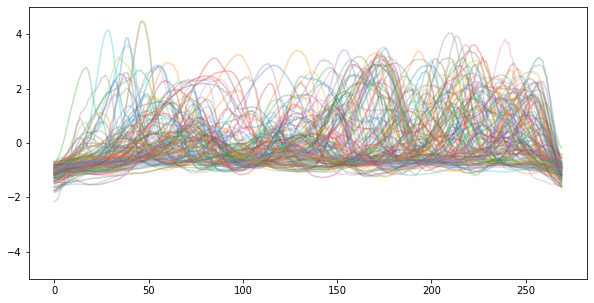

In [ ]:
# plot generated samples
plt.figure(figsize=(10, 5))
plt.plot(x_gen[:,0,:].T, alpha=0.3)
plt.ylim(-5, 5)
plt.show()

## 🌟 Class-Conditional Sampling
Note that you can specify a class condition with `class_index`.

In [ ]:
_, _, x_gen = evaluation.sample(n_samples_to_generate,
                                input_length,
                                n_classes,
                                'conditional',
                                class_index=0)

iter: 1/1


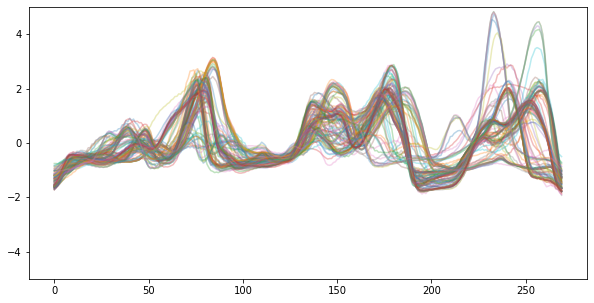

In [ ]:
# plot generated samples
plt.figure(figsize=(10, 5))
plt.plot(x_gen[:,0,:].T, alpha=0.3)
plt.ylim(-5, 5)
plt.show()

In [ ]:
_, _, x_gen = evaluation.sample(n_samples_to_generate,
                                input_length,
                                n_classes,
                                'conditional',
                                class_index=1)

iter: 1/1


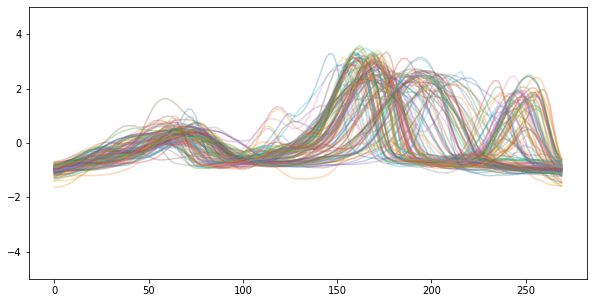

In [ ]:
# plot generated samples
plt.figure(figsize=(10, 5))
plt.plot(x_gen[:,0,:].T, alpha=0.3)
plt.ylim(-5, 5)
plt.show()